# Simple Bézier Interpolation
Reference: https://towardsdatascience.com/b%C3%A9zier-interpolation-8033e9a262c2


In [12]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase 
using Profile    
using Random
using Statistics
using LinearAlgebra
using Distributions
using Plots
#using StatsPlots
using Printf
rng = Random.MersenneTwister(1234);

In [15]:
include("src/Bezier_interpolation.jl")

get_Bezier_vec_Mat_for_all_sites_time (generic function with 1 method)

In [3]:
N = 50; # number of data point
x_set = [ rand()+n for n in 1:(N+1)]; # observed time point
p_set = sin.(pi * 0.3 * 6 * x_set) + 0.1*randn(size(x_set)); # observed value at each time point

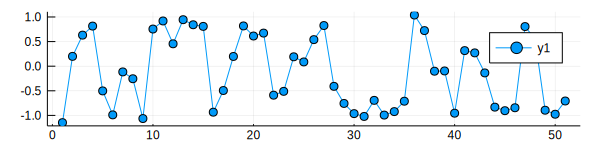

In [6]:
# For check
Plots.plot(p_set, marker=:circle, size=(600,150))

In [16]:
# get interpolation point btw (t,t+dt) for each t
(a_vec, b_vec) = get_a_b_Bezier(N,p_set);

In [17]:
p_set_left = p_set[1:N]
p_set_right = p_set[2:(N+1)];

In [19]:
# Drawing Bézier curve
t= 0.5
n=1
n_grid = 100; grid_scale=1.0/n_grid
Bez_curve = Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n])
for n in 2:N
    Bez_curve = vcat(Bez_curve, Bez.(collect(0:n_grid)*grid_scale, p_set_left[n], p_set_right[n], a_vec[n], b_vec[n]))
end;

In [20]:
#For visiualization
xAxis = [1+i*grid_scale for i in 0:n_grid]
for n in 2:(N)
    xAxis = vcat(xAxis, [1+(n-1)+ i*grid_scale for i in 0:n_grid])
end;    

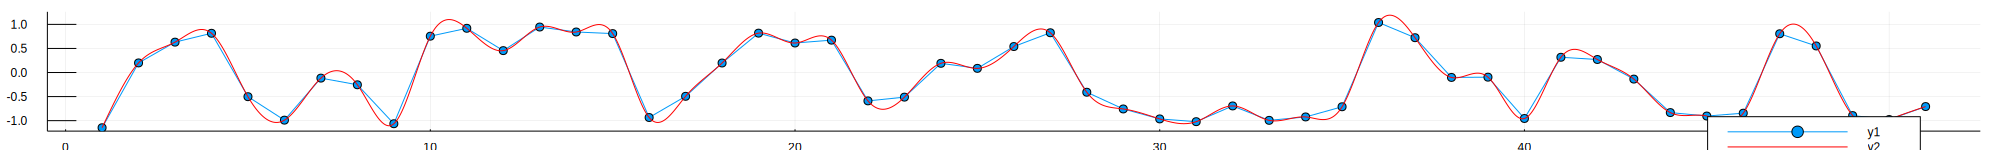

In [21]:
# For check. Note, the Bezier curve through the given data point exactly, so it can be sensitive against underlying data noise.
#Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot(p_set, marker=:circle, size=(600,150))
Plots.plot!(xAxis, Bez_curve, size=(2000,150), color="red")
